# 数据挖掘大作业二

## wine数据集关联规则挖掘预处理

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# 读取数据集并存放在winedata中 显示一下前几个数据先大概观察一下
winedata_file = open("H:\数据挖掘\作业1\wine-reviews\winemag-data-130k-v2.csv",encoding='utf-8')
winedata = pd.read_csv(winedata_file)
winedata = winedata.dropna()
winedata.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks
10,10,US,"Soft, supple plum envelopes an oaky structure ...",Mountain Cuvée,87,19.0,California,Napa Valley,Napa,Virginie Boone,@vboone,Kirkland Signature 2011 Mountain Cuvée Caberne...,Cabernet Sauvignon,Kirkland Signature
23,23,US,This wine from the Geneseo district offers aro...,Signature Selection,87,22.0,California,Paso Robles,Central Coast,Matt Kettmann,@mattkettmann,Bianchi 2011 Signature Selection Merlot (Paso ...,Merlot,Bianchi
25,25,US,Oak and earth intermingle around robust aromas...,King Ridge Vineyard,87,69.0,California,Sonoma Coast,Sonoma,Virginie Boone,@vboone,Castello di Amorosa 2011 King Ridge Vineyard P...,Pinot Noir,Castello di Amorosa
35,35,US,As with many of the Erath 2010 vineyard design...,Hyland,86,50.0,Oregon,McMinnville,Willamette Valley,Paul Gregutt,@paulgwine,Erath 2010 Hyland Pinot Noir (McMinnville),Pinot Noir,Erath


In [3]:
# 获取wine数据集的所有属性信息 除去第一个unamed的字段
# 分析数据集首先可以看出有一个Unamed的字段和description的字段两个比较特殊，首先是Unamed字段这应该是一个索引字段因此没有必要可以删除，另外
# description这一属性是描述性的而在预处理部分我不打算使用NLP相关技术去处理该字段也可以删除。
winedata = winedata.copy().drop(columns=['Unnamed: 0','description'])
winedata.info()
np.array(winedata.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22387 entries, 4 to 129950
Data columns (total 12 columns):
country                  22387 non-null object
designation              22387 non-null object
points                   22387 non-null int64
price                    22387 non-null float64
province                 22387 non-null object
region_1                 22387 non-null object
region_2                 22387 non-null object
taster_name              22387 non-null object
taster_twitter_handle    22387 non-null object
title                    22387 non-null object
variety                  22387 non-null object
winery                   22387 non-null object
dtypes: float64(1), int64(1), object(10)
memory usage: 2.2+ MB


array([['US', "Vintner's Reserve Wild Child Block", 87, 65.0, 'Oregon',
        'Willamette Valley', 'Willamette Valley', 'Paul Gregutt',
        '@paulgwine\xa0',
        "Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley)",
        'Pinot Noir', 'Sweet Cheeks'],
       ['US', 'Mountain Cuvée', 87, 19.0, 'California', 'Napa Valley',
        'Napa', 'Virginie Boone', '@vboone',
        'Kirkland Signature 2011 Mountain Cuvée Cabernet Sauvignon (Napa Valley)',
        'Cabernet Sauvignon', 'Kirkland Signature'],
       ['US', 'Signature Selection', 87, 22.0, 'California',
        'Paso Robles', 'Central Coast', 'Matt Kettmann', '@mattkettmann',
        'Bianchi 2011 Signature Selection Merlot (Paso Robles)',
        'Merlot', 'Bianchi'],
       ['US', 'King Ridge Vineyard', 87, 69.0, 'California',
        'Sonoma Coast', 'Sonoma', 'Virginie Boone', '@vboone',
        'Castello di Amorosa 2011 King Ridge Vineyard Pinot Noir (Sonoma Coast)',
        'Pinot

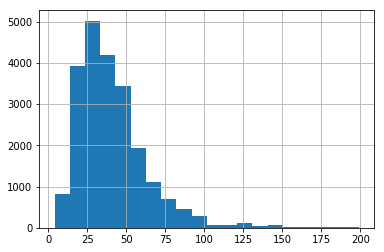

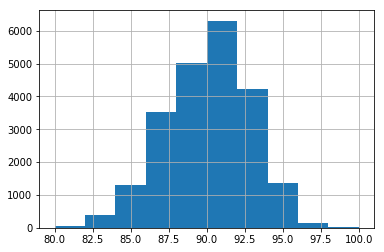

In [4]:
"""]
需要先数据预处理才能有效进行关联规则挖掘，在数据集中可以发现points和price是
连续型数据，因此需要对这两个连续特征作离散化处理，简单的观察两者直方分布情况.
"""
winedata['price'].loc[winedata['price']<200].hist(bins=20)
plt.figure()
winedata['points'].hist()

In [5]:
# 首先处理points
bin = [0,75,80,85,90,95,100]
winedata['points'] = pd.cut(winedata['points'],bin)
winedata['points'] = winedata['points'].astype('str')
# 再处理price
bin = [0,20,30,40,50,60,2100]
winedata['price'] = pd.cut(winedata['price'],bin)
winedata['price'] = winedata['price'].astype('str')
# pd.value_counts(winedata['price'])

## 寻找频繁项集

In [6]:
def createC1( dataSet ):
    """
    构建初始候选项集的列表，即所有候选项集只包含一个元素，
    C1是大小为1的所有候选项集的集合
    """
    C1 = []
    for transaction in np.array(dataSet):
        for item in transaction:
            if [item] not in C1:
                C1.append( [item] )
    C1.sort()
    return list(map( frozenset, C1 ))

def scanD( D, Ck, minSupport ):
    """
    计算Ck中的项集在数据集合D(记录或者transactions)中的支持度,
    返回满足最小支持度的项集的集合，和所有项集支持度信息的字典。
    """
    ssCnt = {}
    for tid in D:
        # 对于每一条transaction
        if Ck is not None:
            for can in Ck:
                # 对于每一个候选项集can，检查是否是transaction的一部分
                # 即该候选can是否得到transaction的支持
                if can.issubset( tid ):
                    ssCnt[ can ] = ssCnt.get( can, 0) + 1
    numItems = float( len( D ) )
    retList = []
    supportData = {}
    for key in ssCnt:
        # 每个项集的支持度
        support = ssCnt[ key ] / numItems
        
        # 将满足最小支持度的项集，加入retList
        if support >= minSupport:
            retList.insert( 0, key )
            
            # 汇总支持度数据
            supportData[ key ] = support
    return retList, supportData

# C1 = createC1(winedata)
# D = list(map(set,np.array(winedata)))
# L,supportData = scanD(D,C1,0.5)
# print(L)

In [7]:
# Aprior算法
def aprioriGen( Lk, k ):
    '''
    由初始候选项集的集合Lk生成新的生成候选项集，
    k表示生成的新项集中所含有的元素个数
    '''
    retList = []
    lenLk = len( Lk )
    for i in range( lenLk ):
        for j in range( i + 1, lenLk ):
            L1 = list( Lk[ i ] )[ : k - 2 ];
            L2 = list( Lk[ j ] )[ : k - 2 ];
            L1.sort();L2.sort()    
            if L1==L2:
                retList.append( Lk[ i ] | Lk[ j ] ) 
    return retList

def apriori( dataSet, minSupport = 0.5 ):
    # 构建初始候选项集C1
    C1 = createC1( dataSet )
    
    # 将dataSet集合化，以满足scanD的格式要求
    D =list( map( set, dataSet ))
    
    # 构建初始的频繁项集，即所有项集只有一个元素
    L1, suppData = scanD( D, C1, minSupport )
    L = [ L1 ]
    # 最初的L1中的每个项集含有一个元素，新生成的
    # 项集应该含有2个元素，所以 k=2
    k = 2
    
    while ( len( L[ k - 2 ] ) > 0 ):
        Ck = aprioriGen( L[ k - 2 ], k )
        Lk, supK = scanD( D, Ck, minSupport )
        
        # 将新的项集的支持度数据加入原来的总支持度字典中
        suppData.update( supK )
        
        # 将符合最小支持度要求的项集加入L
        L.append( Lk )
        
        # 新生成的项集中的元素个数应不断增加
        k += 1
    # 返回所有满足条件的频繁项集的列表，和所有候选项集的支持度信息
    return L, suppData

In [8]:
myDat = list(map(set,np.array(winedata)))
L, suppData = apriori(myDat, 0.05)
L 

[[frozenset({'(80, 85]'}),
  frozenset({'Chardonnay'}),
  frozenset({'Jim Gordon'}),
  frozenset({'@gordone_cellars'}),
  frozenset({'Russian River Valley'}),
  frozenset({'Syrah'}),
  frozenset({'(90, 95]'}),
  frozenset({'Red Blend'}),
  frozenset({'(50, 60]'}),
  frozenset({'(30, 40]'}),
  frozenset({'Washington'}),
  frozenset({'Sean P. Sullivan'}),
  frozenset({'Columbia Valley (WA)'}),
  frozenset({'Columbia Valley'}),
  frozenset({'@wawinereport'}),
  frozenset({'(40, 50]'}),
  frozenset({'Sonoma'}),
  frozenset({'Matt Kettmann'}),
  frozenset({'Central Coast'}),
  frozenset({'@mattkettmann'}),
  frozenset({'(20, 30]'}),
  frozenset({'Virginie Boone'}),
  frozenset({'Napa Valley'}),
  frozenset({'Napa'}),
  frozenset({'California'}),
  frozenset({'Cabernet Sauvignon'}),
  frozenset({'@vboone'}),
  frozenset({'(0, 20]'}),
  frozenset({'Willamette Valley'}),
  frozenset({'US'}),
  frozenset({'Pinot Noir'}),
  frozenset({'Paul Gregutt'}),
  frozenset({'Oregon'}),
  frozenset({'@pau

## 支持度和置信度计算

In [9]:
"""
由于支持度大于0.05的频繁项集很多，取置信度大于0.8的进行分析
"""

def select_conf(L,suppData,thredhold=0.8):
    confList = []
    for itemSet in L:
            for record in itemSet:
                if(len(record)>1): 
                    for i in record: 
                        tar = suppData[frozenset([i])]
                        bset = record - frozenset([i])
                        aset = suppData[record]
                        ret = suppData.get(bset)
                        try:
                            if suppData.get(bset):
                                con = aset/ret
                                if con > thredhold:
                                    confList.append([frozenset([i]),record,con])
                        except TypeError as e:
                            print(e)

    return confList

## 使用Lift 、全自信度进行规则评价

In [207]:
"""
Lift相关系数检
美国X和评分85-90Y的关系设为
lift(X->Y) = supp(X U Y)/supp(X) * supp(Y)
"""
confList = select_conf(L,suppData)
def liftCheck(conList,suppData):
    liftList_true=[]
    liftList_no=[]
    liftList_false=[]
    for item in confList:
        score = suppData.get(item[1])/(suppData.get(item[0])*suppData.get(item[1]-item[0]))
        if score>1:
            liftList_true.append(item)
        if score<1:
            liftList_false.append(item)
        if score ==1:
            liftList_no.append(item)
    return liftList_true,liftList_no,liftList_false

In [208]:
select_conf(L,suppData)

[[frozenset({'US'}), frozenset({'(80, 85]', 'US'}), 1.0],
 [frozenset({'US'}), frozenset({'Chardonnay', 'US'}), 1.0],
 [frozenset({'US'}), frozenset({'@gordone_cellars', 'US'}), 1.0],
 [frozenset({'California'}),
  frozenset({'@gordone_cellars', 'California'}),
  1.0],
 [frozenset({'US'}), frozenset({'Jim Gordon', 'US'}), 1.0],
 [frozenset({'California'}), frozenset({'California', 'Jim Gordon'}), 1.0],
 [frozenset({'@gordone_cellars'}),
  frozenset({'@gordone_cellars', 'Jim Gordon'}),
  1.0],
 [frozenset({'Jim Gordon'}),
  frozenset({'@gordone_cellars', 'Jim Gordon'}),
  1.0],
 [frozenset({'US'}), frozenset({'Russian River Valley', 'US'}), 1.0],
 [frozenset({'@vboone'}),
  frozenset({'@vboone', 'Russian River Valley'}),
  0.9761721752498077],
 [frozenset({'California'}),
  frozenset({'California', 'Russian River Valley'}),
  1.0],
 [frozenset({'Virginie Boone'}),
  frozenset({'Russian River Valley', 'Virginie Boone'}),
  0.9761721752498077],
 [frozenset({'Sonoma'}), frozenset({'Russian

In [209]:
yes,no,false = liftCheck(confList,suppData)

In [214]:
"""查看正相关的关联规则"""
yes

[[frozenset({'California'}),
  frozenset({'@gordone_cellars', 'California'}),
  1.0],
 [frozenset({'California'}), frozenset({'California', 'Jim Gordon'}), 1.0],
 [frozenset({'@gordone_cellars'}),
  frozenset({'@gordone_cellars', 'Jim Gordon'}),
  1.0],
 [frozenset({'Jim Gordon'}),
  frozenset({'@gordone_cellars', 'Jim Gordon'}),
  1.0],
 [frozenset({'@vboone'}),
  frozenset({'@vboone', 'Russian River Valley'}),
  0.9761721752498077],
 [frozenset({'California'}),
  frozenset({'California', 'Russian River Valley'}),
  1.0],
 [frozenset({'Virginie Boone'}),
  frozenset({'Russian River Valley', 'Virginie Boone'}),
  0.9761721752498077],
 [frozenset({'Sonoma'}), frozenset({'Russian River Valley', 'Sonoma'}), 1.0],
 [frozenset({'Columbia Valley'}),
  frozenset({'@wawinereport', 'Columbia Valley'}),
  0.9097408400357463],
 [frozenset({'Columbia Valley'}),
  frozenset({'Columbia Valley', 'Columbia Valley (WA)'}),
  1.0],
 [frozenset({'Sean P. Sullivan'}),
  frozenset({'@wawinereport', 'Sean P

In [215]:
"""
全自信度检验
全自信度all_confidence的定义如下：
all_confidence(A,B)=P(A交B)/max{P(A),P(B)}
 =min{P(B|A),P(A|B)}
 =min{confidence(A—>B),confidence(B—>A)}

"""
def all_confidence(conList,suppData):
    result = []
    for item in confList:
        score = suppData.get(item[1])/max(suppData.get(item[0]),suppData.get(item[1]-item[0]))
        result.append(['全自信度为:{0}'.format(score),item])
    return result
    

In [216]:
all_confidence(confList,suppData)

[['全自信度为:0.07830437307365883',
  [frozenset({'US'}), frozenset({'(80, 85]', 'US'}), 1.0]],
 ['全自信度为:0.10751775584044311',
  [frozenset({'US'}), frozenset({'Chardonnay', 'US'}), 1.0]],
 ['全自信度为:0.08554071559387144',
  [frozenset({'US'}), frozenset({'@gordone_cellars', 'US'}), 1.0]],
 ['全自信度为:0.14844961240310076',
  [frozenset({'California'}),
   frozenset({'@gordone_cellars', 'California'}),
   1.0]],
 ['全自信度为:0.08554071559387144',
  [frozenset({'US'}), frozenset({'Jim Gordon', 'US'}), 1.0]],
 ['全自信度为:0.14844961240310076',
  [frozenset({'California'}), frozenset({'California', 'Jim Gordon'}), 1.0]],
 ['全自信度为:1.0',
  [frozenset({'@gordone_cellars'}),
   frozenset({'@gordone_cellars', 'Jim Gordon'}),
   1.0]],
 ['全自信度为:1.0',
  [frozenset({'Jim Gordon'}),
   frozenset({'@gordone_cellars', 'Jim Gordon'}),
   1.0]],
 ['全自信度为:0.058114084066645824',
  [frozenset({'US'}), frozenset({'Russian River Valley', 'US'}), 1.0]],
 ['全自信度为:0.19775770787916536',
  [frozenset({'@vboone'}),
   frozenset({'@